## IST 707 DATA ANALYTICS HOMEWORK 3

## DISEASE PREDICTION USING NBC, KNN, SVM AND ENSEMBLE LEARNING METHODS

### Submitted by YESWANTH REDDY VELAPALEM on 5th April 2020

### EXECUTIVE SUMMARY :
*This report provides analysis and evaluation of several classification techniques that are used to solve a binary classification which helps in predicting whether or not a patient has a certain unspecified disease. Methods of building a good classification model include identifying the data quality issues, finding the data patterns, building a base model and tuning the required hyperparameters to improve the performance of the model.*

*In this assignment, Classification models are built using training data and perform extenisve hyperparameter tuning and in turn used to make predictions on test data to produce good Accuracy, Recall, Precision and AUCROC scores. The goal is to produce unbiased and low variance estimates.*

### INTRODUCTION :
*Health complications are the no.1 cause of death in the world. The best approcah to reduce the death rate is early detection of the disease. In this assignment we will implement models including Naive Bayes, KNN and Support Vector Machine (SVM),Random Forest and Gradient Boosting to predict the probability of a patient having a disease based on results from medical examinations, such as blood pressure values and Cholesterol, Glucose etc.*

In [1]:
import warnings
warnings.filterwarnings('ignore')

**Importing required libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB ,MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC , LinearSVC #support vector Machine
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier #Random Forest
from sklearn.tree import plot_tree, export_graphviz
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report,accuracy_score,f1_score,recall_score,precision_score

**Setting the plot style and palette**

In [3]:
%matplotlib inline
sb.set_palette('hls')

### SECTION 1 : DATA PREPARATION

**Reading the data**

In [4]:
df = pd.read_csv('Disease Prediction Training.csv')

**Exploring the data**

In [5]:
print('Dimensions of the dataset :',df.shape)
df.head()

Dimensions of the dataset : (49000, 12)


,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
0,59,female,167,88.0,130,68,normal,normal,0,0,1,0
1,64,female,150,71.0,140,100,normal,normal,0,0,0,1
2,41,female,166,83.0,100,70,normal,normal,0,1,1,0
3,50,male,172,110.0,130,80,normal,normal,1,0,1,0
4,39,female,162,61.0,110,80,high,high,0,0,1,0


*The dataset has 49000 observations and 12 features.The data contains mixed features (categorical and numerical). In numerical features,all are integers except for weight which is decimal.*

#### Data Preparation Steps :
**Inspect Missing Values :**
*Inspect each feature for NA values. If more than 75% of the feature contains NA, we replace that field with 0. If less than 75% is NA, then the median value of the column is used to replace the NA.*

**Encoding Categorical Variables :**
*Check for any categorical variables and using proper methods (like label encoding) to convert them to numerical variables.*

**Removing Duplicates :**
*Remove all duplicate entries in the dataset.*

**Dealing with Outliers :**
*Search each feature for any outliers and remove them from dataset. We will keep the entries between 95% quantile and 5% quantile for those features which have outliers or incorrect data. We are going to replace the values that are greater than 95% quantile with the 95% quantile value and values that are lower than 5% quantile with the 5% quantile value.*

**Feature engineering :**
*Adding new variable called Body mass index (BMI)*


**Checking for missing values in the data**

In [6]:
df.isnull().sum()

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
Disease                0
dtype: int64

*There are no missing values in the dataset.*

**Checking for duplicate records**

In [7]:
duplicateRowsDF = df[df.duplicated(keep='first')]

print('\nThere are {} duplicated entries in the dataset.'.format(len(duplicateRowsDF)))
duplicateRowsDF.head()


There are 1752 duplicated entries in the dataset.


,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
1278,40,female,156,65.0,110,80,normal,normal,0,0,1,0
1581,56,female,160,60.0,120,80,normal,normal,0,0,1,1
1901,54,female,170,80.0,120,80,normal,normal,0,0,1,0
2412,41,female,162,65.0,110,70,normal,normal,0,0,1,0
3027,56,female,169,70.0,120,80,normal,normal,0,0,1,0


**Removing duplicates**

In [8]:
df.drop_duplicates(keep = 'first', inplace = True) 
df.shape

(47248, 12)

**Label encoding categorical variables**

In [9]:
df.replace({'Gender':{'female':0,'male':1}},inplace=True)
df.replace({'Cholesterol':{'normal':0,'high':1,'too high':2}},inplace=True)
df.replace({'Glucose':{'normal':0,'high':1,'too high':2}},inplace=True)



**Dealing with Outliers**

**Generating the descriptive statistics**

In [10]:
df.describe()

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
count,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000
mean,52.863126,0.354999,164.352735,74.442470,129.013461,97.557209,0.378640,0.233407,0.091411,0.056235,0.799378,0.509567
std,6.791208,0.478518,8.314608,14.469526,150.324461,204.020137,0.687169,0.579308,0.288196,0.230378,0.400470,0.499914
min,29.000000,0.000000,55.000000,10.000000,-150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,1.000000,207.000000,200.000000,14020.000000,11000.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


*From the above table, we can observe some extremely high values associated with High blood pressure and Low Blood pressure variables. There is a high chance for the presence of outliers in these variables. Also there seem to negative values in the High Blood Pressure which might have crept in due to a data entry error.*

**Visualizing outliers**

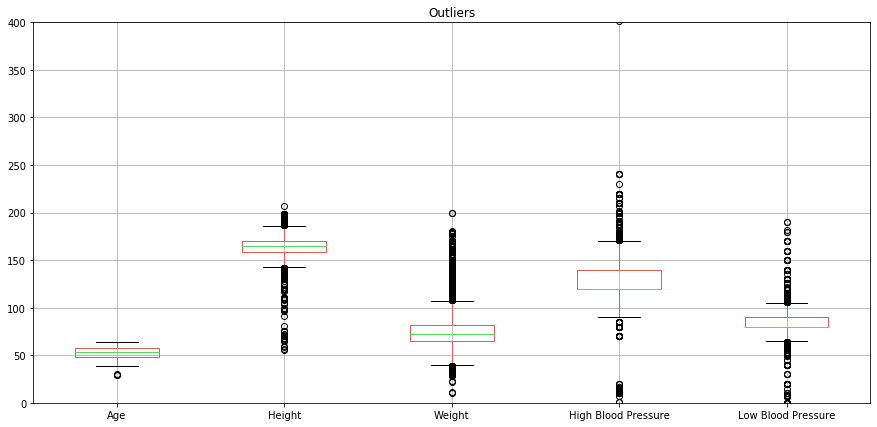

In [11]:
outlier = df[['Age','Height','Weight','High Blood Pressure','Low Blood Pressure']]

plt.figure(figsize = (15,7))
a = outlier.boxplot()
a.set_ylim(0,400)
plt.title('Outliers')
plt.show()

*Here I set the max limit of y-axis to 400 to visualize all the outliers clearly since the scale of blood pressure is much higher. Some of the outliers in blood pressure columns are not displayed since we clipped the y-axis but we can get a clear picture of the presence of outliers. We can observe that except Age all the other numerical features have outliers. High Blood Pressure and Low Blood Pressure have unusually high number of outliers.*

**Calculating outlier boundaries**

In [12]:
limit = pd.DataFrame(index=['Lower','Upper'])

for i in ['High Blood Pressure','Low Blood Pressure','Height','Weight']:
    IQR = df[i].quantile(0.75) - df[i].quantile(0.25)
    Lower = df[i].quantile(0.25) - (IQR * 3)
    Upper = df[i].quantile(0.75) + (IQR * 3)
    limit[i]= [Lower,Upper]
limit

,High Blood Pressure,Low Blood Pressure,Height,Weight
Lower,60.0,50.0,126.0,14.0
Upper,200.0,120.0,203.0,133.0


**Winsorizing outliers**

In [13]:
def max_(x,var,upp):
    return np.where(x[var]>upp,upp,x[var])
def min_(x,var,low):
    return np.where(x[var]<low,low,x[var])

In [14]:
df['High Blood Pressure'] = max_(df,'High Blood Pressure',200)
df['Low Blood Pressure'] = max_(df,'Low Blood Pressure',120)
df['Height'] = max_(df,'Height',203)
df['Weight'] = max_(df,'Weight',133)
df['High Blood Pressure'] = min_(df,'High Blood Pressure',60)
df['Low Blood Pressure'] = min_(df,'Low Blood Pressure',50)
df['Height'] = min_(df,'Height',126)
df['Weight'] = min_(df,'Weight',14)

**Visualization of categorical variables**

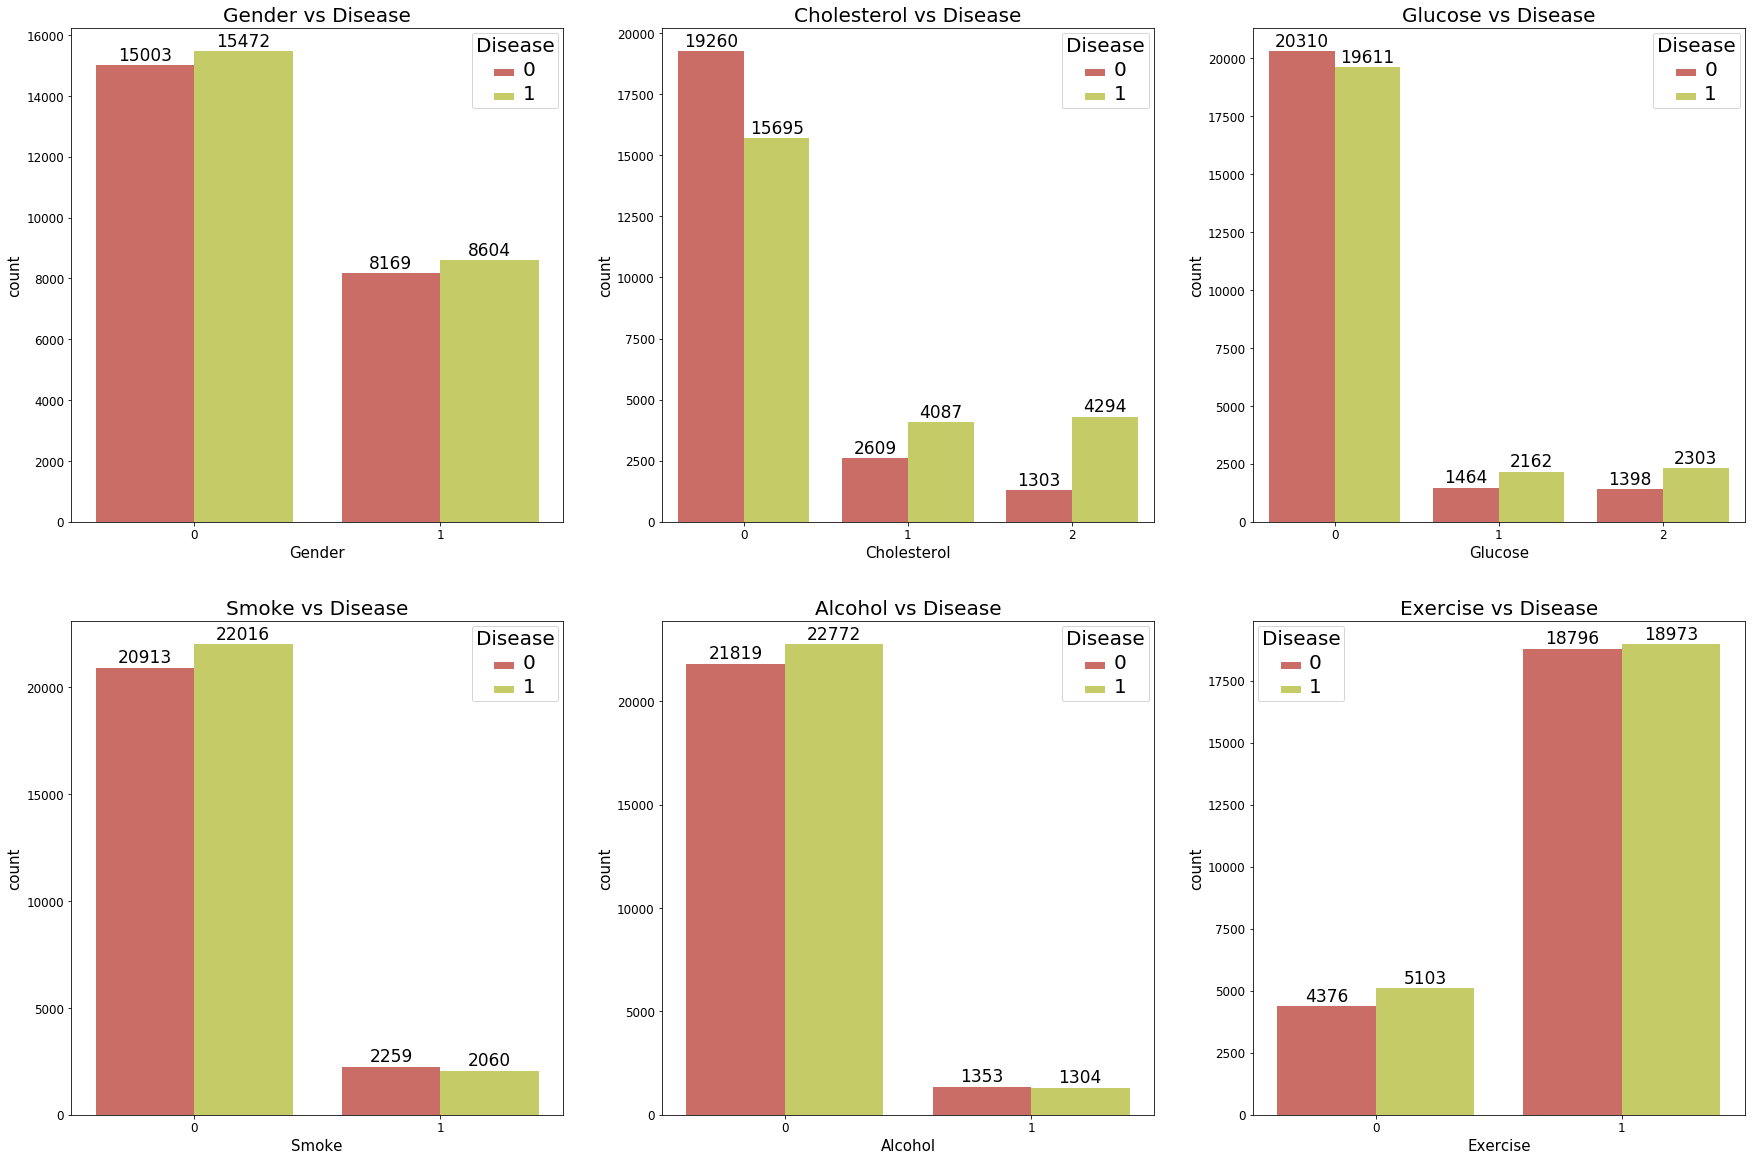

In [15]:
cat = ['Gender','Cholesterol','Glucose','Smoke','Alcohol','Exercise']

plt.figure(figsize=(30,20))

for i in range(len(cat)):
    #creating subplots
    plt.subplot(2,3,i+1)
    #plotting
    b = sb.countplot(df[cat[i]],hue=df['Disease'])
    #setting x and y labels
    b.set_xlabel(cat[i],fontsize=15)
    b.set_ylabel('count',fontsize=15)
    b.tick_params(labelsize=12)
    #size of legend
    plt.setp(b.get_legend().get_texts(), fontsize='20')
    plt.setp(b.get_legend().get_title(), fontsize='20')
    #title 
    plt.title('{} vs Disease'.format(cat[i]),fontsize=20)
    #values on top of bars
    for p in b.patches:
        b.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 17)

**Interpretation of countplots**

*For Gender, we find that there are more female patients with disease than males.*

*For Cholesterol, we can observe the percentage of the people with disease are high where cholesterol range is high and too high.*

*For Glucose, we can observe the percentage of the people with disease are high where Glucose range is high and too high.*

*For Smoke, Alcohol, Exercise there is no significant difference between smoker and non-smoker groups.*

**Visualization of numerical variables**

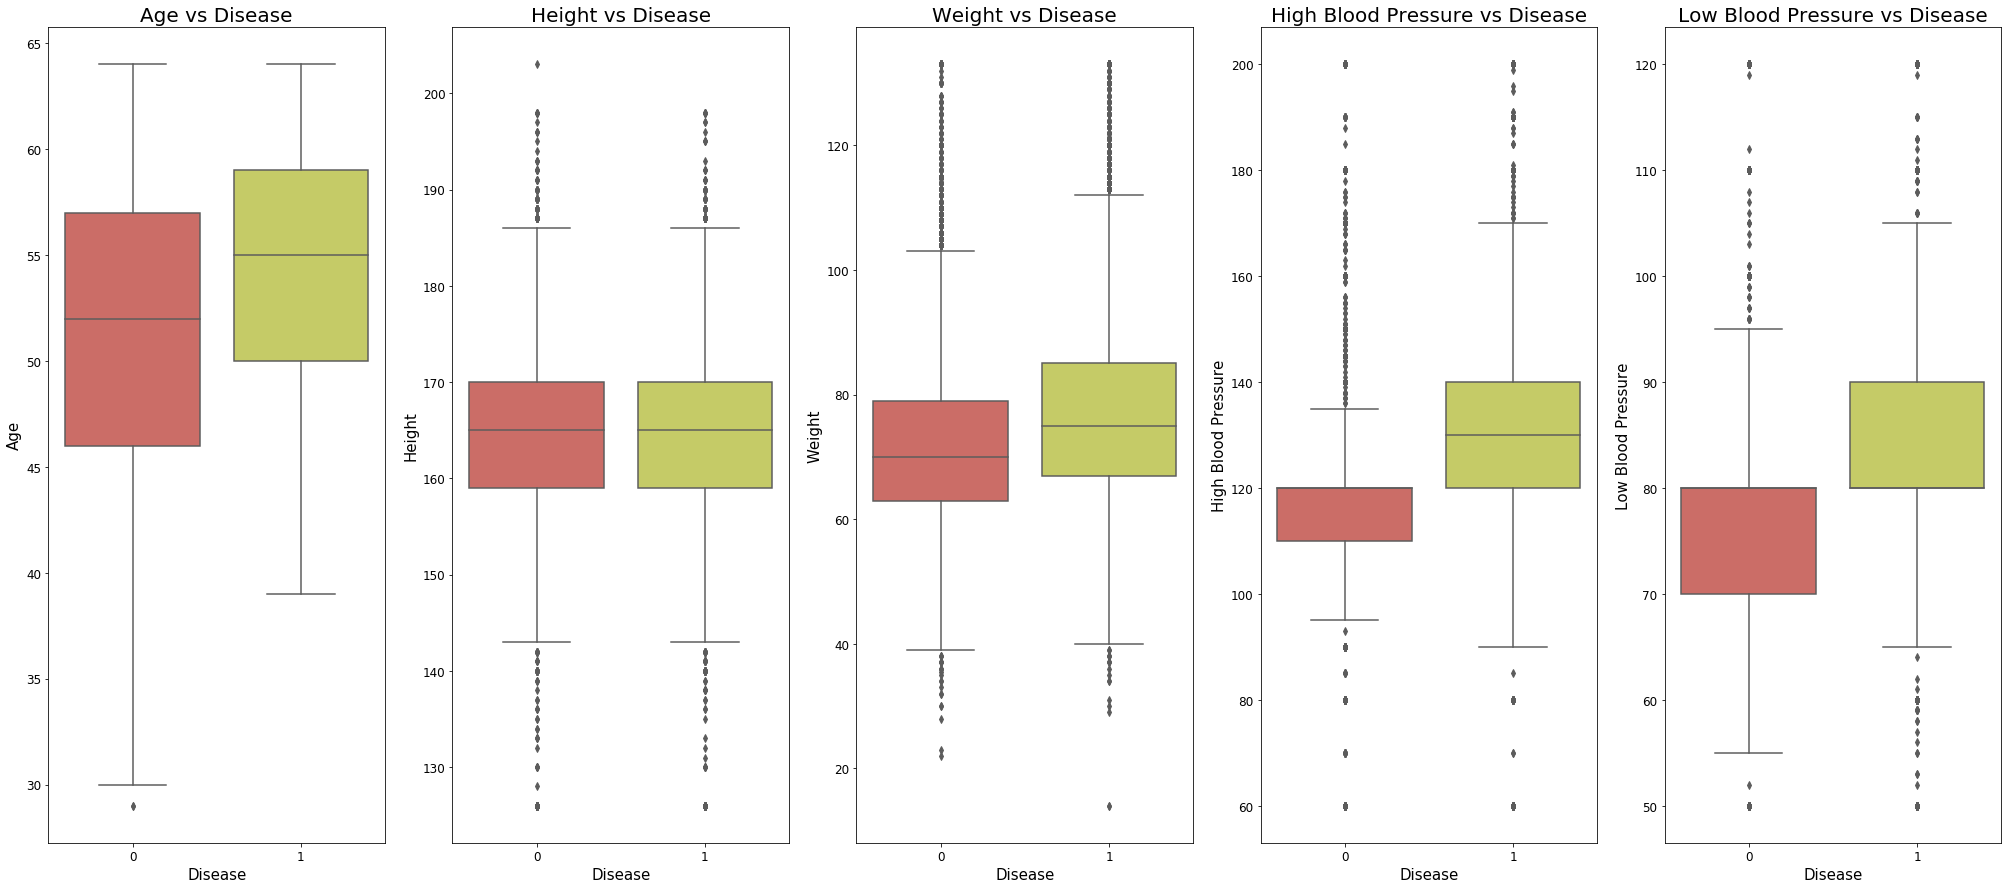

In [16]:
num = ['Age','Height','Weight','High Blood Pressure','Low Blood Pressure']

plt.figure(figsize=(35,15))

for i in range(len(num)):
    #creating subplots
    plt.subplot(1,5,i+1)
    #plotting
    a = sb.boxplot(x='Disease', y=num[i], data=df)
    #setting x and y axis labels
    a.set_xlabel('Disease',fontsize = 15)
    a.set_ylabel(num[i], fontsize = 15)
    a.tick_params(labelsize = 12)
    #plot title
    plt.title('{} vs Disease'.format(num[i]), fontsize = 20)

**Interpretation of boxplots**

*For Age, we can observe that elder people tend to have a high risk of heart disease.*

*For Height, we can observe that risk of heart disease doesnot depend on height.*

*For weight, we can observe that heavier people tend to have a high risk of heart disease.*

*For High Blood Pressure , if the values are higher than 120 and lower than 90, there is a risk of heart disease.*

*For Low Blood Pressure, if the values are higher than 80 and lower than 60, there is a risk of heart disease.*

**Exploring Target Variable**

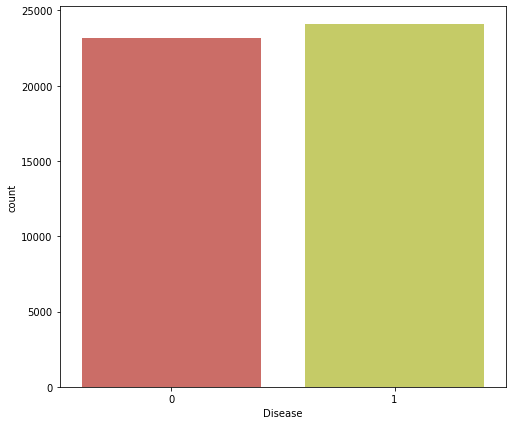

In [17]:
plt.figure(figsize=(8,7))

sb.countplot(df['Disease'])

*The data seems to be balanced.*

**Adding a new feature Body Mass Index (BMI)**

*The blood pressure is mainly influenced by factors such as smoking, being overweight or obese (indicated by body mass index), alcohol consumption, older age etc. Since there is no body mass index feature we can calculate it from height and weight using the formula below:*
 
$$Body Mass Index (BMI) = \frac{weight_{kilograms}}{height_{metres}^{2}}$$

In [18]:
df.insert(4,'BMI', round(df['Weight']/((df['Height']/100)**2),1)) 

**looking at final data prepared for modeling**

In [19]:
df.head()

,Age,Gender,Height,Weight,BMI,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
0,59,0,167,88.0,31.6,130,68,0,0,0,0,1,0
1,64,0,150,71.0,31.6,140,100,0,0,0,0,0,1
2,41,0,166,83.0,30.1,100,70,0,0,0,1,1,0
3,50,1,172,110.0,37.2,130,80,0,0,1,0,1,0
4,39,0,162,61.0,23.2,110,80,1,1,0,0,1,0


**Correlation Matrix**

*Correlation matrix returns a table with correlation coeffiecients between all the variables in the data. Here we can observe the relation between all the features whether it is positive or negative, strong or weak etc.*

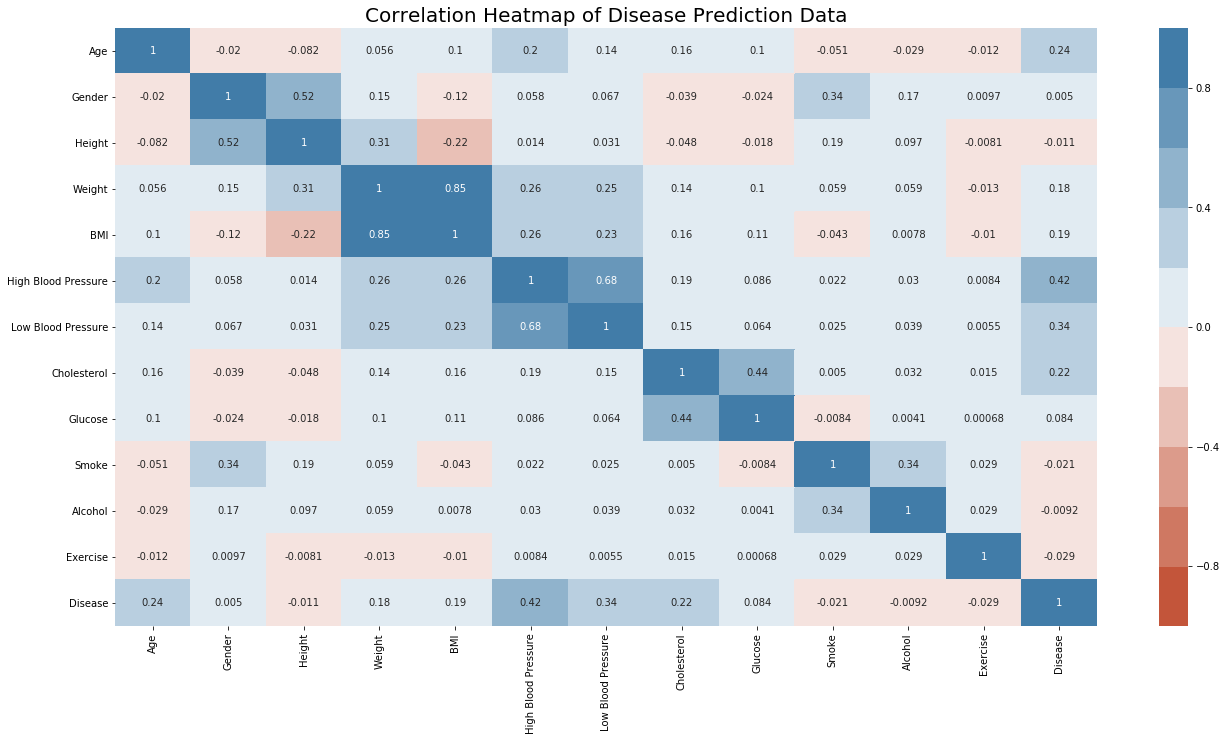

In [20]:
plt.figure(figsize=(22,11))

plt.title('Correlation Heatmap of Disease Prediction Data',fontsize=20)
sb.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap=sb.diverging_palette(20, 240,n=10))
plt.show()

### SECTION 2 : MODELING, HYPER PARAMETER TUNING AND PERFORMANCE EVALUATION

**Classification Models :**

*Naive Bayes Classifier*<br/>
*K-Nearest Neighbors*<br/>
*Linear Support Vector Machine*<br/>
*Non-Linear Support Vector Machine*<br/>
*Random Forest Classifier*<br/>
*Gradient Boosting Machine*<br/>

**Choice of Performance Evaluation Metrics**

**ROC curve:**
*A receiver operating characteristic curve, which is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. A ROC curve can be used to select a threshold for a classifier which maximizes the true positives, while minimizing the false positives.*

*The true-positive rate is also known as sensitivity or recall.* 
*The false-positive rate is also known as (1 − specificity).* 


**AUC score:** 
*The AUC represents a model’s ability to discriminate between positive and negative classes. AUC values ranges from 0 to 1. An area of 1.0 represents a model that made all predictions perfectly. An area of 0.5 represents a model as *<br/>

*In addition to ROC-AUC metric, we use the other classification metrics in our models such as:*

* **Accuracy:** *It is the proportion of the total number of predictions that were correct over all kinds predictions made. Accuracy is a good measure when the target variable classes in the data are nearly balanced.*<br/>
*Accuracy = (TP + TN)/(TP + FP + FN + TN)*

* **Precision:** 
*It is also called Positive Predictive Value and is the proportion of positive cases that were correctly identified.*<br/>
*Precision = (TP) / (TP + FP)*

* **Recall or Sensitivity:** 
*It is the proportion of actual positive cases which are correctly identified.*<br/>
*Recall = (TP) / (TP + FN)*

* **F1 score:**
*f1 score is the harmonic mean of precision and recall.*<br/>

*Recall gives us information about a model performance with respect to false negatives , while precision gives us information about its performance with respect to false positives.*

*Since the dataset give is balanced, we would want to maximize our Accuracy close to 100% without precision and recall too bad.*

**Making a copy of data**

In [21]:
df_1 = df.copy()

### NAIVE BAYES CLASSIFIER

*Naive Bayes classifier is a probabilistic machine learning model that’s used for classification task. The foundation of the classifier is based on the Bayes theorem.*<br/>
*Instead of calculating the values of each attribute value P(x1, x2, x3|y), they are assumed to be conditionally independent given the target value and calculated as P(x1|y)* * *P(x2|y)* * *P(x3|y).*

**Selecting feature and target variables**

In [22]:
X_nbc = df_1.drop(['Disease'],axis = 1)
y_nbc = df_1['Disease']

**Splitting into train and test data**

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X_nbc,y_nbc,test_size = 0.3, random_state = 42)

**Running the model**

In [24]:
nbc = GaussianNB(priors=None, var_smoothing = 1e-09)
nbc.fit(X_train,y_train)
nbc_pred = nbc.predict(X_test)

**Calculating performance evaluation metrics**

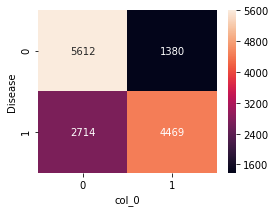

In [25]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,nbc_pred),annot=True,fmt='d')
plt.show()

In [26]:
print('Accuracy:',round(accuracy_score(y_test,nbc_pred)*100,2))
print('Recall:',round(recall_score(y_test,nbc_pred)*100,2))
print('Precision:',round(precision_score(y_test,nbc_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,nbc_pred)*100,2))

Accuracy: 71.12
Recall: 62.22
Precision: 76.41
F1 Score: 68.59


**Generating ROC curve**

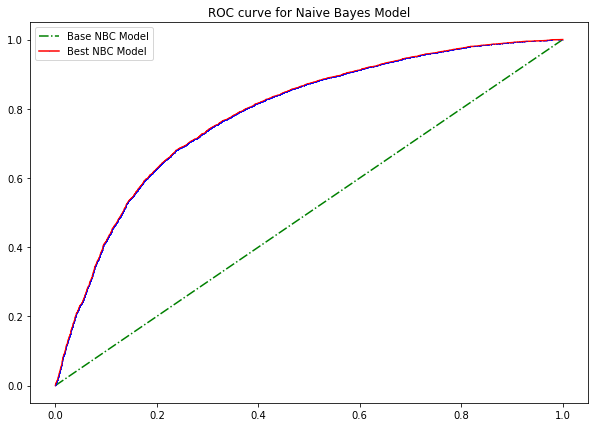

In [27]:
plt.figure(figsize=(10,7))
base_nbc_probs = [0 for _ in range(len(y_test))]

best_nbc_probs = nbc.predict_proba(X_test)
best_nbc_probs = best_nbc_probs[:, 1]

base_nbc_fpr, base_nbc_tpr, _ = roc_curve(y_test, base_nbc_probs)
best_nbc_fpr, best_nbc_tpr, _ = roc_curve(y_test, best_nbc_probs)

plt.plot(base_nbc_fpr, base_nbc_tpr, linestyle='dashdot', label='Base NBC Model',color='Green')
plt.plot(best_nbc_fpr, best_nbc_tpr, marker='x', label='Best NBC Model',color='Red',markeredgecolor='blue',markersize=0.1)

plt.title('ROC curve for Naive Bayes Model')

plt.legend()

plt.show()

**Calculating AUC**

In [28]:
best_nbc_auc = roc_auc_score(y_test, best_nbc_probs)

print('Area under the curve for Naive bayes model is %.3f' % (best_nbc_auc))

Area under the curve for Naive bayes model is 0.783


*Since the auc score is closer to 1, we can say that it has a good measure of seperatability.*

**Table summarising naive bayes model**

In [29]:
best = {'priors':None, 'var_smoothing':1e-09}
nbc_table = pd.DataFrame(best,index=['best model values'])
nbc_table

,priors,var_smoothing
best model values,None,1.000000e-09


### K-NEAREST NEIGHBORS CLASSIFIER

*The k-nearest neighbors (KNN) algorithm is a simple supervised machine learning algorithm that can be used to solve both classification and regression problems. The KNN algorithm assumes that similar things exist in close proximity.*




**Selecting feature and target variables**

In [30]:
X_knn = df_1.drop(['Disease'],axis = 1)
y_knn = df_1['Disease']

**Scaling the feature variables**

*Since KNN is a distance based algorithm and the features are calculated on different scales we can use StandardScaler to bring the data on same scale.*

In [31]:
scaled_knn = StandardScaler().fit_transform(X_knn)

**Splitting into train and test data**

In [32]:
X_train,X_test,y_train,y_test = train_test_split(scaled_knn,y_knn,test_size = 0.3, random_state = 42)

**Running the baseline model**

In [33]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

**Calculating performance evaluation metrics**

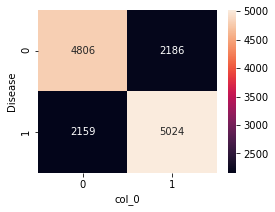

In [34]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,knn_pred),annot=True,fmt='d')
plt.show()

In [35]:
print('Accuracy:',round(accuracy_score(y_test,knn_pred)*100,2))
print('Recall:',round(recall_score(y_test,knn_pred)*100,2))
print('Precision:',round(precision_score(y_test,knn_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,knn_pred)*100,2))

Accuracy: 69.35
Recall: 69.94
Precision: 69.68
F1 Score: 69.81


**Hyperparameter tuning for KNN**

**GridSearch Parameters:**

**n_neighbors:** *Number of neighbors to use in the analysis.*

**p:** *Power parameter for the Minkowski metric.*
* *When p = 1, this is equivalent to using manhattan_distance (l1),*
* *When p = 2, this is equivalent to using euclidean_distance (l2),*

*For arbitrary p, minkowski_distance is used.*

**weights:** *Both uniform and distance are looked at.*

*    *'uniform' : uniform weights. All points in each neighborhood are weighted equally.*

*    *'distance' : weight points by the inverse of their distance. In this case, closer neighbors of a query point       will have a greater influence than neighbors which are further away.*

**algorithm:** *Algorithm is left as 'auto' and it will attempt to choose the appropriate algorithm based on the values given to the model.*

*We are going to run gridsearch with a combination of hyperparameters to improve the accuracy of the KNN classifier.*

In [36]:
param_grid_knn = {'n_neighbors' : list(range(21,31)),
                  'weights': ['uniform','distance'],
                  'algorithm' : ['auto'],'p' : [1,2]}
grid_knn = GridSearchCV(knn, param_grid_knn, cv=6, scoring='accuracy')

In [37]:
#grid_knn.fit(X_train, y_train)

In [38]:
#grid_knn.best_params_

In [39]:
#grid_knn.best_score_

*Now we can tune our model by using the optimal parameters from the gridsearch.*

**Running the model with tuned parameters**

In [40]:
knn_tuned = KNeighborsClassifier(n_neighbors=27, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
knn_tuned.fit(X_train,y_train)
knn_tuned_pred = knn_tuned.predict(X_test)

**Calculating performance evaluation metrics**

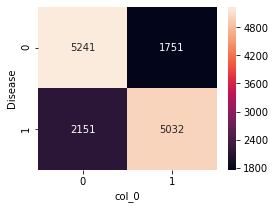

In [41]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,knn_tuned_pred),annot=True,fmt='d')
plt.show()

In [42]:
print('Accuracy:',round(accuracy_score(y_test,knn_tuned_pred)*100,2))
print('Recall:',round(recall_score(y_test,knn_tuned_pred)*100,2))
print('Precision:',round(precision_score(y_test,knn_tuned_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,knn_tuned_pred)*100,2))

Accuracy: 72.47
Recall: 70.05
Precision: 74.19
F1 Score: 72.06


**Generating ROC curve**

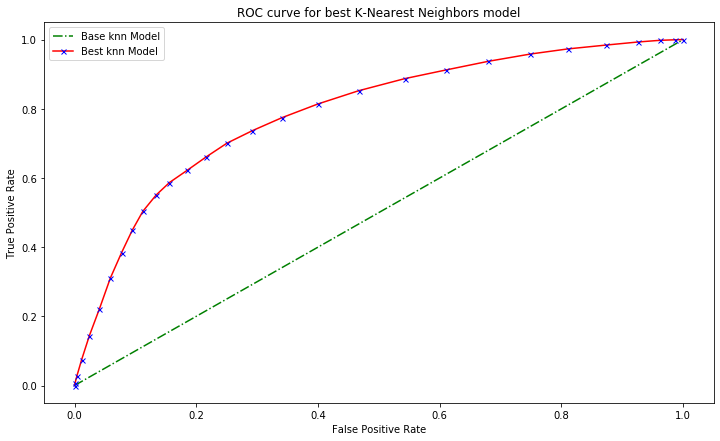

In [43]:
plt.figure(figsize=(12,7))
base_knn_probs = [0 for _ in range(len(y_test))]

best_knn_probs = knn_tuned.predict_proba(X_test)
best_knn_probs = best_knn_probs[:, 1]

base_knn_fpr, base_knn_tpr, _ = roc_curve(y_test, base_knn_probs)
best_knn_fpr, best_knn_tpr, _ = roc_curve(y_test, best_knn_probs)

plt.plot(base_knn_fpr, base_knn_tpr, linestyle='dashdot', label='Base knn Model',color='Green')
plt.plot(best_knn_fpr, best_knn_tpr, marker='x', label='Best knn Model',color='Red',markeredgecolor='blue',markersize=5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve for best K-Nearest Neighbors model')

plt.legend()

plt.show()

**Calculating AUC score**

In [44]:
best_knn_auc = roc_auc_score(y_test, best_knn_probs)
print('Area under the curve for KNN model is %.3f' % (best_knn_auc))

Area under the curve for KNN model is 0.789


**Table summarising KNN model**

In [45]:
base_knn = pd.DataFrame({'algorithm':'auto', 'metric':'minkowski','n_neighbors':5, 'p':2,'weights':'uniform',
                         'Accuracy':round(accuracy_score(y_test,knn_pred)*100,2),
                         'Recall':round(recall_score(y_test,knn_pred)*100,2),
                         'Precision':round(precision_score(y_test,knn_pred)*100,2),
                         'F1 Score':round(f1_score(y_test,knn_pred)*100,2)},index=['base knn model'])
tuned_knn = pd.DataFrame({'algorithm':'auto', 'metric':'minkowski','n_neighbors':27, 'p':2,'weights':'uniform',
                         'Accuracy':round(accuracy_score(y_test,knn_tuned_pred)*100,2),
                         'Recall':round(recall_score(y_test,knn_tuned_pred)*100,2),
                         'Precision':round(precision_score(y_test,knn_tuned_pred)*100,2),
                         'F1 Score':round(f1_score(y_test,knn_tuned_pred)*100,2)},index=['tuned knn model'])

knn_table = pd.concat([tuned_knn,base_knn])
knn_table

,algorithm,metric,n_neighbors,p,weights,Accuracy,Recall,Precision,F1 Score
tuned knn model,auto,minkowski,27,2,uniform,72.47,70.05,74.19,72.06
base knn model,auto,minkowski,5,2,uniform,69.35,69.94,69.68,69.81


*For KNN, the tuning of hyperparameters produced better results compared to the base model.*

### LINEAR SUPPORT VECTOR MACHINE

*Support-vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection.A good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class, since in general the larger the margin, the lower the generalization error of the classifier.*

**Selecting feature and target variables**

In [46]:
X_lsvm = df_1.drop(['Disease'],axis = 1)
y_lsvm = df_1['Disease']

**Scaling the feature variables**

*Since SVM is a distance based algorithm and the features are calculated on different scales we can use StandardScaler to bring the data on same scale.*

In [47]:
scaled_lsvm = StandardScaler().fit_transform(X_lsvm)

**Splitting into train and test data**

In [48]:
X_train,X_test,y_train,y_test = train_test_split(scaled_lsvm,y_lsvm,test_size=0.3,random_state=42)

**Running the baseline model**

In [49]:
lsvm = LinearSVC()

In [50]:
lsvm.fit(X_train,y_train)
lsvm_pred = lsvm.predict(X_test)

**Calculating performance evaluation methods**

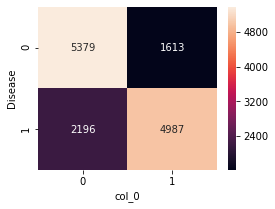

In [51]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,lsvm_pred),annot=True,fmt='d')
plt.show()

In [52]:
print('Accuracy:',round(accuracy_score(y_test,lsvm_pred)*100,2))
print('Recall:',round(recall_score(y_test,lsvm_pred)*100,2))
print('Precision:',round(precision_score(y_test,lsvm_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,lsvm_pred)*100,2))

Accuracy: 73.13
Recall: 69.43
Precision: 75.56
F1 Score: 72.36


**Hyperparameter tuning**

**GridSearch Parameters:**

**C:** *Regularization parameter. The strength of the regularization is inversely proportional to C.*
* *By increasing C, the bias is reduced and variance is increased thereby increasing the risk of overfitting.*

* *By decreasing C the variance will decrease and reduce the risk of overfitting, but the bias increases which in turn increases the risk of underfitting.*

*Hence an optimum value of C has to be chosen so that we get an unbiased and low variance model.*

**penalty:** *Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC.*

**loss:** *Specifies the loss function. ‘hinge’ is the standard SVM loss while ‘squared_hinge’ is the square of the hinge loss.*

In [53]:
param_grid_lsvm = {'C':[0.01,0.1,1,10,100],'penalty':['l1','l2'],'loss':['hinge','squared_hinge']}
grid_lsvm = GridSearchCV(lsvm, param_grid_lsvm, cv=6, scoring='accuracy')

In [54]:
#grid_lsvm.fit(X_train,y_train)

In [55]:
#grid_lsvm.best_params_

In [56]:
#grid_lsvm.best_score_

**Running the model with tuned parameters**

In [57]:
lsvm_tuned = LinearSVC(C=1, loss='hinge', penalty='l2')
lsvm_tuned.fit(X_train,y_train)
lsvm_tuned_pred = lsvm_tuned.predict(X_test)

**Calculating performance evaluation metrics**

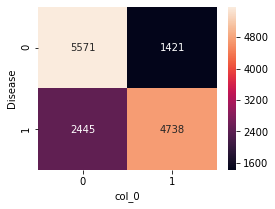

In [58]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,lsvm_tuned_pred),annot=True,fmt='d')
plt.show()

In [59]:
print('Accuracy:',round(accuracy_score(y_test,lsvm_tuned_pred)*100,2))
print('Recall:',round(recall_score(y_test,lsvm_tuned_pred)*100,2))
print('Precision:',round(precision_score(y_test,lsvm_tuned_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,lsvm_tuned_pred)*100,2))

Accuracy: 72.73
Recall: 65.96
Precision: 76.93
F1 Score: 71.02


**Table summarising linear svm model**

In [60]:
base_lsvm = pd.DataFrame({'C':1.0,'penalty':'l2','loss':'squared_hinge',
                         'Accuracy':round(accuracy_score(y_test,lsvm_pred)*100,2),
                         'Recall':round(recall_score(y_test,lsvm_pred)*100,2),
                         'Precision':round(precision_score(y_test,lsvm_pred)*100,2),
                         'F1 Score':round(f1_score(y_test,lsvm_pred)*100,2)},index=['base lsvm model'])
tuned_lsvm = pd.DataFrame({'C':1.0,'penalty':'l2','loss':'hinge',
                         'Accuracy':round(accuracy_score(y_test,lsvm_tuned_pred)*100,2),
                         'Recall':round(recall_score(y_test,lsvm_tuned_pred)*100,2),
                         'Precision':round(precision_score(y_test,lsvm_tuned_pred)*100,2),
                         'F1 Score':round(f1_score(y_test,lsvm_tuned_pred)*100,2)},index=['tuned lsvm model'])

lsvm_table = pd.concat([base_lsvm,tuned_lsvm])
lsvm_table

,C,penalty,loss,Accuracy,Recall,Precision,F1 Score
base lsvm model,1.0,l2,squared_hinge,73.13,69.43,75.56,72.36
tuned lsvm model,1.0,l2,hinge,72.73,65.96,76.93,71.02


### NON-LINEAR SUPPORT VECTOR MACHINE

**Selecting feature and target variables**

In [61]:
X_rbf = df_1.drop(['Disease'],axis = 1)
y_rbf = df_1['Disease']

**Scaling the feature variables**

*Since SVM is a distance based algorithm and the features are calculated on different scales we can use StandardScaler to bring the data on same scale.*

In [62]:
scaled_rbf= StandardScaler().fit_transform(X_rbf)

**Splitting into train and test data**

In [63]:
X_train,X_test,y_train,y_test = train_test_split(scaled_rbf,y_rbf, test_size = 0.3, random_state = 42)

**Running the base model**

In [64]:
rbf = SVC(kernel='rbf')
rbf.fit(X_train,y_train)
rbf_pred = rbf.predict(X_test)

**Calculating performance evaluation metrics**

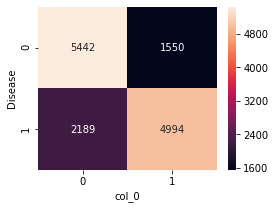

In [65]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,rbf_pred),annot=True,fmt='d')
plt.show()

In [66]:
print('Accuracy:',round(accuracy_score(y_test,rbf_pred)*100,2))
print('Recall:',round(recall_score(y_test,rbf_pred)*100,2))
print('Precision:',round(precision_score(y_test,rbf_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,rbf_pred)*100,2))

Accuracy: 73.62
Recall: 69.53
Precision: 76.31
F1 Score: 72.76


**Hyperparameter tuning**

**GridSearch parameters:**

**C:** *Regularization parameter. The strength of the regularization is inversely proportional to C.*
* *By increasing C, the bias is reduced and variance is increased thereby increasing the risk of overfitting.*

* *By decreasing C the variance will decrease and reduce the risk of overfitting, but the bias increases which in turn increases the risk of underfitting.*

*Hence an optimum value of C has to be chosen so that we get an unbiased and low variance model.*

**gamma:** *Gamma is a parameter of Gaussian kernel to handle non-linear classification. It defines how far influence of a single training example reaches, with lower values meaning far and higher values meaning close.*
* *Lower gamma values will lead to high bias and low variance.*
* *Higher gamma values will lead to low bias and high variance.*



In [67]:
param_grid_rbf = { 'C': [ 0.5, 1, 5, 10], 'gamma': [0.001, 0.01, 0.1, 1] }
grid_rbf = GridSearchCV(rbf, param_grid=param_grid_rbf,cv=3, scoring='accuracy', n_jobs= -1, verbose = 2)

In [68]:
#grid_rbf.fit(X_train,y_train)

In [69]:
#grid_rbf.best_params_

In [70]:
#grid_rbf.best_score_

**Running the model with tuned parameters**

In [71]:
rbf_tuned = SVC(kernel='rbf', C = 10, gamma=0.01)
rbf_tuned.fit(X_train,y_train)
rbf_tuned_pred = rbf_tuned.predict(X_test)

**Calculating performance evaluation metrics**

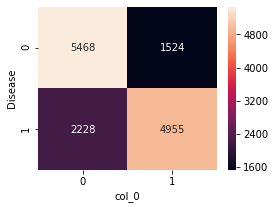

In [72]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,rbf_tuned_pred),annot=True,fmt='d')
plt.show()

In [73]:
print('Accuracy:',round(accuracy_score(y_test,rbf_tuned_pred)*100,2))
print('Recall:',round(recall_score(y_test,rbf_tuned_pred)*100,2))
print('Precision:',round(precision_score(y_test,rbf_tuned_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,rbf_tuned_pred)*100,2))

Accuracy: 73.53
Recall: 68.98
Precision: 76.48
F1 Score: 72.54


**Table summarising Non linear svm model**

In [74]:
base_rbf = pd.DataFrame({'C':1.0,'gamma':'scale',
                         'Accuracy':round(accuracy_score(y_test,rbf_pred)*100,2),
                         'Recall':round(recall_score(y_test,rbf_pred)*100,2),
                         'Precision':round(precision_score(y_test,rbf_pred)*100,2),
                         'F1 Score':round(f1_score(y_test,rbf_pred)*100,2)},index=['base rbf model'])
tuned_rbf = pd.DataFrame({'C':10,'gamma':0.01,
                         'Accuracy':round(accuracy_score(y_test,rbf_tuned_pred)*100,2),
                         'Recall':round(recall_score(y_test,rbf_tuned_pred)*100,2),
                         'Precision':round(precision_score(y_test,rbf_tuned_pred)*100,2),
                         'F1 Score':round(f1_score(y_test,rbf_tuned_pred)*100,2)},index=['tuned rbf model'])

rbf_table = pd.concat([base_rbf,tuned_rbf])
rbf_table

,C,gamma,Accuracy,Recall,Precision,F1 Score
base rbf model,1.0,scale,73.62,69.53,76.31,72.76
tuned rbf model,10.0,0.01,73.53,68.98,76.48,72.54


*The performance displayed by baseline non linear svm and tuned non linear svm models are very similar.*

### RANDOM FOREST CLASSIFIER

*Random forest is an ensemble learning method for classification that operate by constructing a multitude of decision trees. Each decision tree gives out a class prediction and the class with most votes becomes the model's prediction. Random decision forests correct for decision trees' habit of overfitting to their training set.*

**Selecting feature and target variables**

In [75]:
X_rf = df_1.drop(['Disease'],axis = 1)
y_rf = df_1['Disease']

**Splitting into train and test data**

In [76]:
X_train,X_test,y_train,y_test = train_test_split(X_rf,y_rf,test_size=0.3,random_state=42)

**Running the baseline model**

In [77]:
rf = RandomForestClassifier()

In [78]:
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

**Calculating performance evaluation metrics**

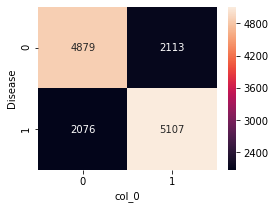

In [79]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,rf_pred),annot=True,fmt='d')
plt.show()

In [80]:
print('Accuracy:',round(accuracy_score(y_test,rf_pred)*100,2))
print('Recall:',round(recall_score(y_test,rf_pred)*100,2))
print('Precision:',round(precision_score(y_test,rf_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,rf_pred)*100,2))

Accuracy: 70.45
Recall: 71.1
Precision: 70.73
F1 Score: 70.92


**Hyperparameter tuning**

**GridSearch parameters:**

**criterion:**
*The function to measure the quality of a split. Supported criteria are 'gini' for the Gini impurity and 'entropy' for the information gain.*

**min_samples_leaf:** *The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.*

**min_samples_split:** *The number of samples to split an internal node.*

**max_depth:** *The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.*

**max_features:** *The number of features to consider when looking for the best split.*
* *If 'auto', then max_features=sqrt(n_features).*
* *If 'log2', then max_features=log2(n_features).*

**n_estmimators:** *The number of trees in the forest.**

In [81]:
param_grid_rf = { 'criterion': ['gini', 'entropy'],
                   'min_samples_leaf': [4, 6, 8, 10],
                   'min_samples_split': [10, 15, 20],
                   'max_depth': [5, 10, 15],
                   'max_features': ['auto','log2'],
                   'n_estimators': [200, 400, 600, 800]}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs= -1, verbose = 2)

In [82]:
#grid_rf.fit(X_train,y_train)

In [83]:
#grid_rf.best_params_

In [84]:
#grid_rf.best_score_

**Running the model with tuned parameters**

In [85]:
rf_tuned = RandomForestClassifier(criterion ='entropy', min_samples_leaf= 4, min_samples_split= 10,max_depth=10,max_features='log2',n_estimators=400)
rf_tuned.fit(X_train,y_train)
rf_tuned_pred = rf_tuned.predict(X_test)

**Calculating performance evaluation metrics**

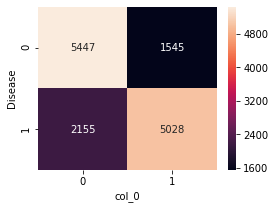

In [86]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,rf_tuned_pred),annot=True,fmt='d')
plt.show()

In [87]:
print('Accuracy:',round(accuracy_score(y_test,rf_tuned_pred)*100,2))
print('Recall:',round(recall_score(y_test,rf_tuned_pred)*100,2))
print('Precision:',round(precision_score(y_test,rf_tuned_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,rf_tuned_pred)*100,2))

Accuracy: 73.9
Recall: 70.0
Precision: 76.49
F1 Score: 73.1


**Plotting one of the trees of random forest model**

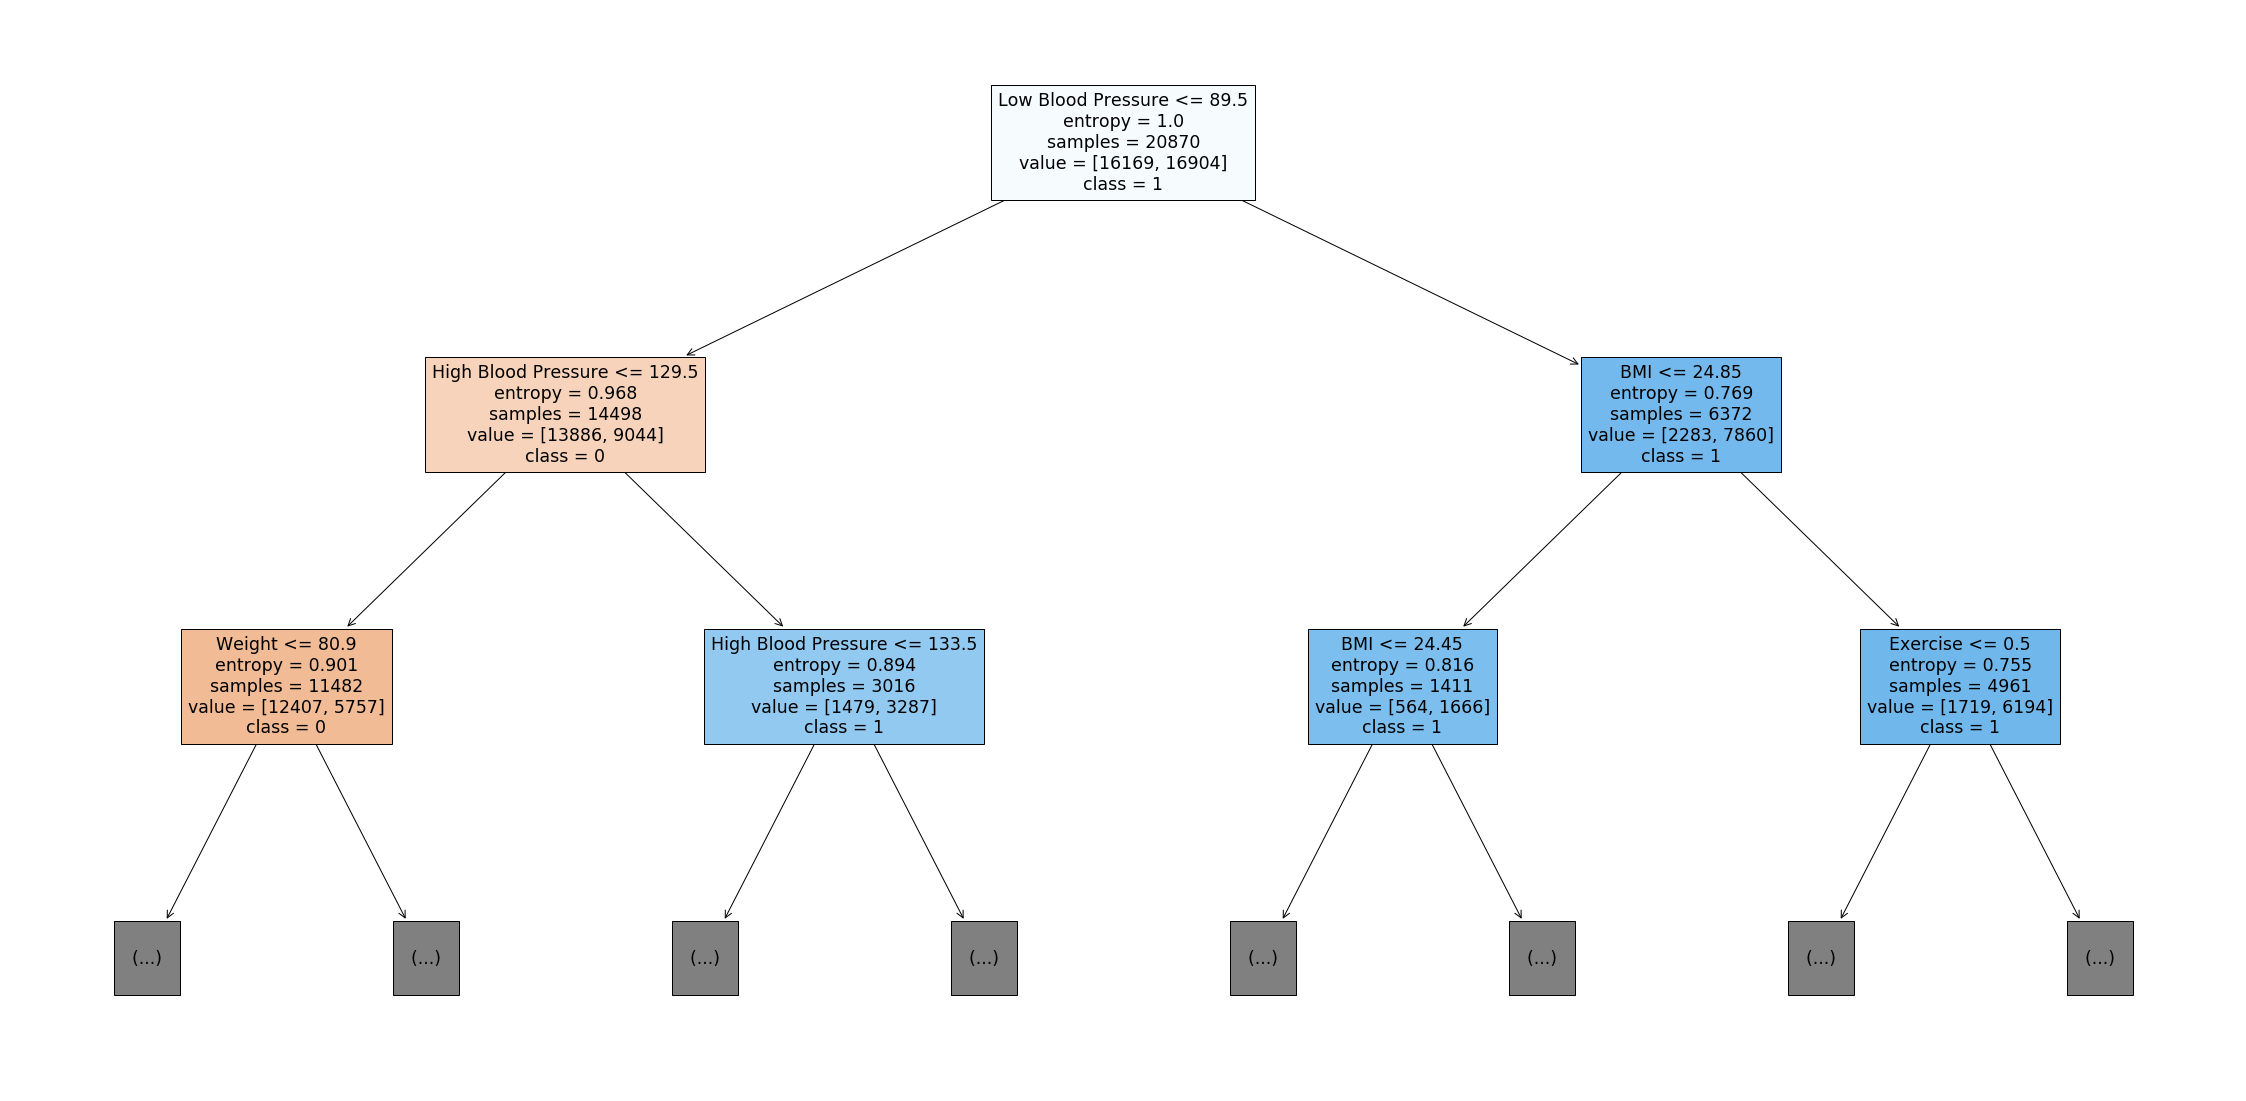

In [88]:
plt.figure(figsize=(40,20))
plot_tree(rf_tuned.estimators_[1],max_depth=2,filled=True,feature_names=X_rf.columns,class_names=['0','1'],)
plt.show()

**Generating ROC curve**

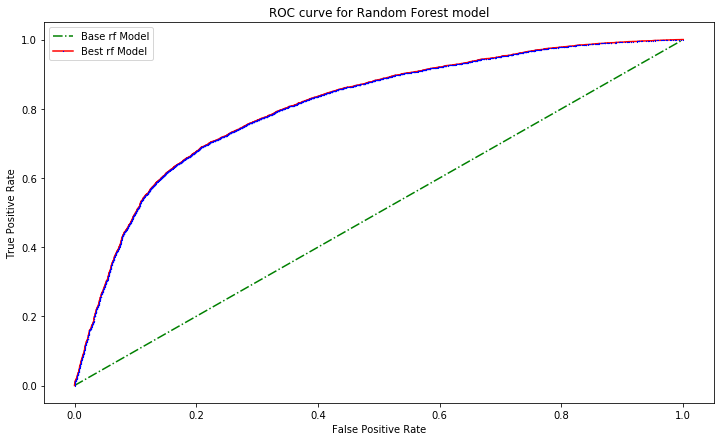

In [89]:
plt.figure(figsize=(12,7))
base_rf_probs = [0 for _ in range(len(y_test))]

best_rf_probs = rf_tuned.predict_proba(X_test)
best_rf_probs = best_rf_probs[:, 1]

base_rf_fpr, base_rf_tpr, _ = roc_curve(y_test, base_rf_probs)
best_rf_fpr, best_rf_tpr, _ = roc_curve(y_test, best_rf_probs)

plt.plot(base_rf_fpr, base_rf_tpr, linestyle='dashdot', label='Base rf Model',color='Green')
plt.plot(best_rf_fpr, best_rf_tpr, marker='x', label='Best rf Model',color='Red',markeredgecolor='blue',markersize=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve for Random Forest model')

plt.legend()

plt.show()

**Calculating AUC score**

In [90]:
best_rf_auc = roc_auc_score(y_test, best_rf_probs)
print('Area under the curve for RF model is %.3f' % (best_rf_auc))

Area under the curve for RF model is 0.806


**Table summarising random forest model**

In [91]:
base_rf = pd.DataFrame({'criterion':'gini','min_samples_leaf':1,'min_samples_split':2,'max_depth': None,
           'max_features':'auto','n_estimators':100,
           'Accuracy':round(accuracy_score(y_test,rf_pred)*100,2),
           'Recall':round(recall_score(y_test,rf_pred)*100,2),
           'Precision':round(precision_score(y_test,rf_pred)*100,2),
           'F1 Score':round(f1_score(y_test,rf_pred)*100,2)},index=['base rf model'])

tuned_rf = pd.DataFrame({'criterion':'entropy','min_samples_leaf':4,'min_samples_split':10,'max_depth': 10,
           'max_features':'log2','n_estimators':400,
           'Accuracy':round(accuracy_score(y_test,rf_tuned_pred)*100,2),
           'Recall':round(recall_score(y_test,rf_tuned_pred)*100,2),
           'Precision':round(precision_score(y_test,rf_tuned_pred)*100,2),
           'F1 Score':round(f1_score(y_test,rf_tuned_pred)*100,2)},index=['tuned rf model'])

rf_table = pd.concat([base_rf,tuned_rf])
rf_table

,criterion,min_samples_leaf,min_samples_split,max_depth,max_features,n_estimators,Accuracy,Recall,Precision,F1 Score
base rf model,gini,1,2,None,auto,100,70.45,71.1,70.73,70.92
tuned rf model,entropy,4,10,10,log2,400,73.90,70.0,76.49,73.10


*The model constructed by using the parameters after tuning by running the gridsearch produced better accuracy compared to the baseline model.*

### GRADIENT BOOSTING MACHINE

*Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the models in a stage-wise fashion. The final prediction model is taken by making weighted average of predictions amde by each weak model.*

**Selecting feature and target variables**

In [92]:
X_gbm = df_1.drop(['Disease'],axis = 1)
y_gbm = df_1['Disease']

**Splitting into train and test data**

In [93]:
X_train,X_test,y_train,y_test = train_test_split(X_gbm,y_gbm, test_size = 0.3, random_state = 42)

**Running the baseline model**

In [94]:
gbm = GradientBoostingClassifier()

In [95]:
gbm.fit(X_train,y_train)
gbm_pred = gbm.predict(X_test)

**Calculating performance evaluation metrics**

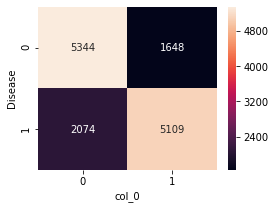

In [96]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,gbm_pred),annot=True,fmt='d')
plt.show()

In [97]:
print('Accuracy:',round(accuracy_score(y_test,gbm_pred)*100,2))
print('Recall:',round(recall_score(y_test,gbm_pred)*100,2))
print('Precision:',round(precision_score(y_test,gbm_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,gbm_pred)*100,2))

Accuracy: 73.74
Recall: 71.13
Precision: 75.61
F1 Score: 73.3


**Hyperparameter tuning**

**GridSearch Parameters:**

**learning_rate:** *learning rate shrinks the contribution of each tree by learning_rate value. There is a trade-off between learning_rate and n_estimators.*

**n_estimators:** *The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.*

**max_depth:** *maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree.*

In [98]:
param_grid_gbm = {'learning_rate': np.arange(0.02, 0.1, 0.02),
                  'n_estimators': [200, 400, 600, 700],
                  'max_depth': range(2, 5)}
grid_gbm = GridSearchCV(gbm, param_grid_gbm,cv=3, scoring='accuracy', n_jobs= -1, verbose = 2)

In [99]:
#grid_gbm.fit(X_train,y_train)

In [100]:
#grid_gbm.best_params_

In [101]:
#grid_gbm.best_score_

**Running the model with tuned parameters**

In [102]:
gbm_tuned = GradientBoostingClassifier(learning_rate=0.02, max_depth=3,n_estimators=400)

In [103]:
gbm_tuned.fit(X_train,y_train)
gbm_tuned_pred = gbm_tuned.predict(X_test) 

**Calculating performance evaluation metrics**

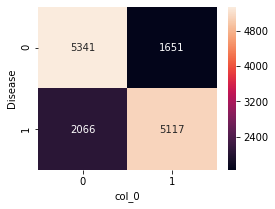

In [104]:
plt.figure(figsize=(4,3))
sb.heatmap(pd.crosstab(y_test,gbm_tuned_pred),annot=True,fmt='d')
plt.show()

In [105]:
print('Accuracy:',round(accuracy_score(y_test,gbm_tuned_pred)*100,2))
print('Recall:',round(recall_score(y_test,gbm_tuned_pred)*100,2))
print('Precision:',round(precision_score(y_test,gbm_tuned_pred)*100,2))
print('F1 Score:',round(f1_score(y_test,gbm_tuned_pred)*100,2))

Accuracy: 73.78
Recall: 71.24
Precision: 75.61
F1 Score: 73.36


**Plotting one of the decision trees (weak model) of GBM**

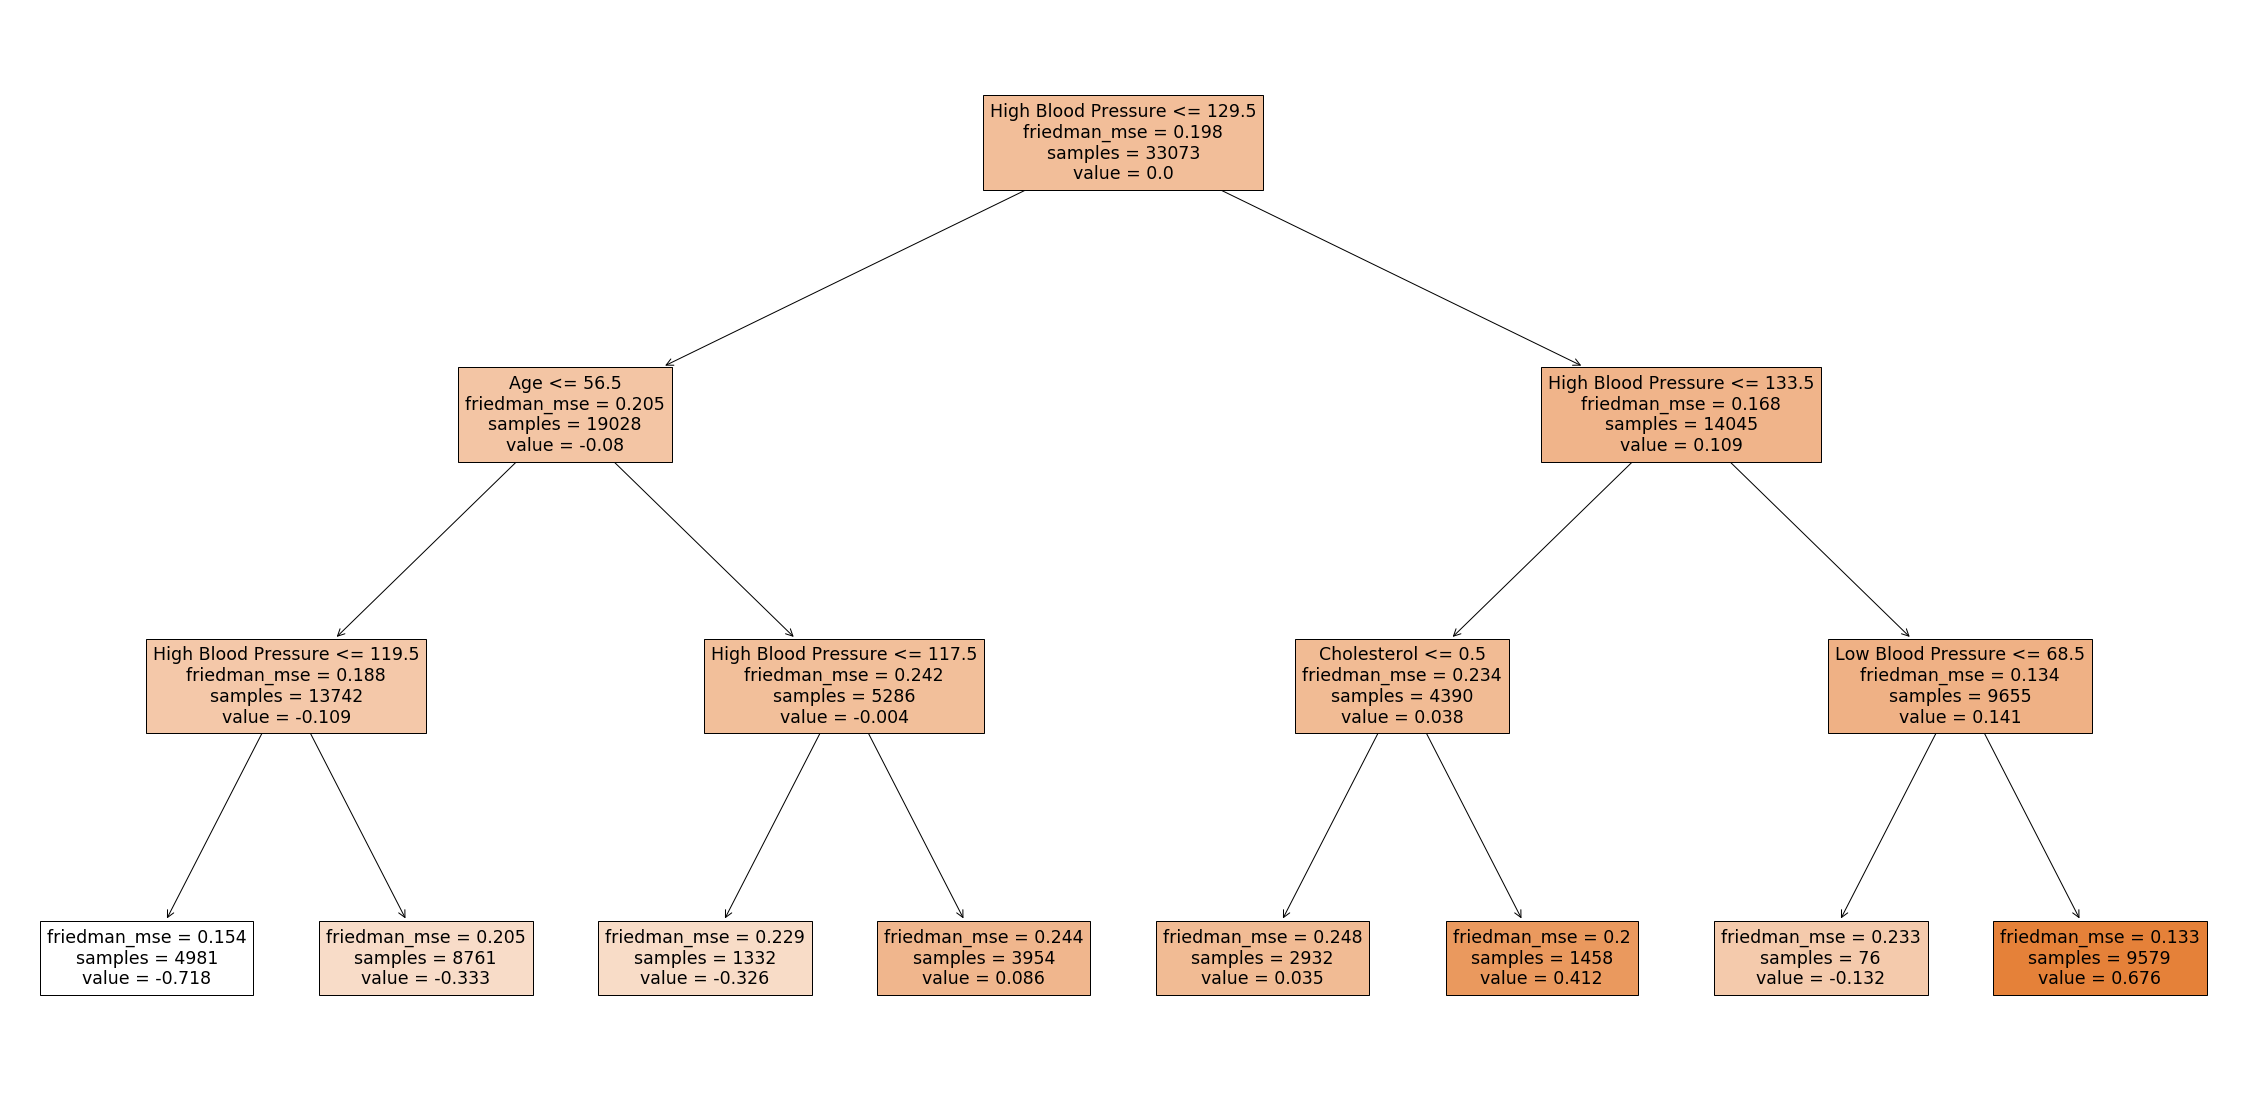

In [106]:
plt.figure(figsize=(40,20))
plot_tree(gbm_tuned.estimators_[42,0],max_depth=3,filled=True,feature_names=X_rf.columns,class_names=['0','1'],)
plt.show()

**Generating ROC curve**

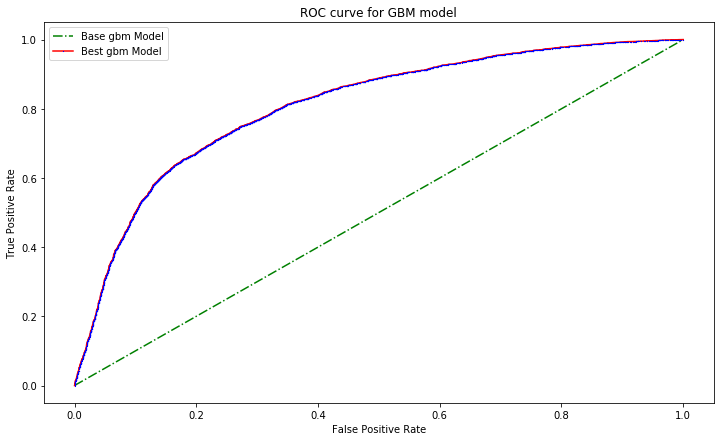

In [107]:
plt.figure(figsize=(12,7))
base_gbm_probs = [0 for _ in range(len(y_test))]

best_gbm_probs = gbm_tuned.predict_proba(X_test)
best_gbm_probs = best_gbm_probs[:, 1]

base_gbm_fpr, base_gbm_tpr, _ = roc_curve(y_test, base_gbm_probs)
best_gbm_fpr, best_gbm_tpr, _ = roc_curve(y_test, best_gbm_probs)

plt.plot(base_gbm_fpr, base_gbm_tpr, linestyle='dashdot', label='Base gbm Model',color='Green')
plt.plot(best_gbm_fpr, best_gbm_tpr, marker='x', label='Best gbm Model',color='Red',markeredgecolor='blue',markersize=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve for GBM model')

plt.legend()

plt.show()

**Calculating AUC score**

In [108]:
best_gbm_auc = roc_auc_score(y_test, best_gbm_probs)
print('Area under the curve for GBM model is %.3f' % (best_gbm_auc))

Area under the curve for GBM model is 0.808


**Table summarising gbm model**

In [109]:
base_gbm = pd.DataFrame({'learning_rate': 1.0,'n_estimators': 100,'max_depth': 3,
                        'Accuracy':round(accuracy_score(y_test,gbm_pred)*100,2),
                        'Recall':round(recall_score(y_test,gbm_pred)*100,2),
                        'Precision':round(precision_score(y_test,gbm_pred)*100,2),
                        'F1 Score':round(f1_score(y_test,gbm_pred)*100,2)},index=['base gbm model'])

tuned_gbm = pd.DataFrame({'learning_rate': 0.02,'n_estimators': 400,'max_depth': 3,
                         'Accuracy':round(accuracy_score(y_test,gbm_tuned_pred)*100,2),
                         'Recall':round(recall_score(y_test,gbm_tuned_pred)*100,2),
                         'Precision':round(precision_score(y_test,gbm_tuned_pred)*100,2),
                         'F1 Score':round(f1_score(y_test,gbm_tuned_pred)*100,2)},index=['tuned gbm model'])


gbm_table = pd.concat([base_gbm,tuned_gbm])
gbm_table

,learning_rate,n_estimators,max_depth,Accuracy,Recall,Precision,F1 Score
base gbm model,1.00,100,3,73.74,71.13,75.61,73.30
tuned gbm model,0.02,400,3,73.78,71.24,75.61,73.36


*The performance metrics for GBM are almost similar for both baseline and tuned model.*

## Test data

**Reading the test data**

In [110]:
main = pd.read_csv('Disease Prediction Testing.csv')

**Exploring the test data**

In [111]:
main.head()

,ID,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise
0,0,44,female,160,59.0,100,80,high,normal,0,0,1
1,1,41,female,169,74.0,120,70,normal,normal,0,0,1
2,2,63,male,168,84.0,120,80,normal,high,0,0,1
3,3,55,female,158,108.0,160,100,normal,normal,0,0,0
4,4,55,female,167,67.0,120,80,normal,normal,0,0,1


**dropping ID column and storing in a new dataframe**

In [112]:
test = main.drop(['ID'],axis=1)

**DATA PREPARATION**

*The data preparation methods for test data is same as the methods used for train data.*

**Checking missing values**

In [113]:
test.isnull().sum()

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
dtype: int64

*There are no missing values in the test dataset.*

**Checking for duplicate records**

In [114]:
duplicaterows_test = test[test.duplicated(keep='first')]

print('There are {} duplicated entries in the dataset.'.format(len(duplicaterows_test)))

There are 566 duplicated entries in the dataset.


In [115]:
test.drop_duplicates(keep = 'first', inplace = True) 
test.shape

(20434, 11)

**Dealing with outliers**

**Visualizing outliers**

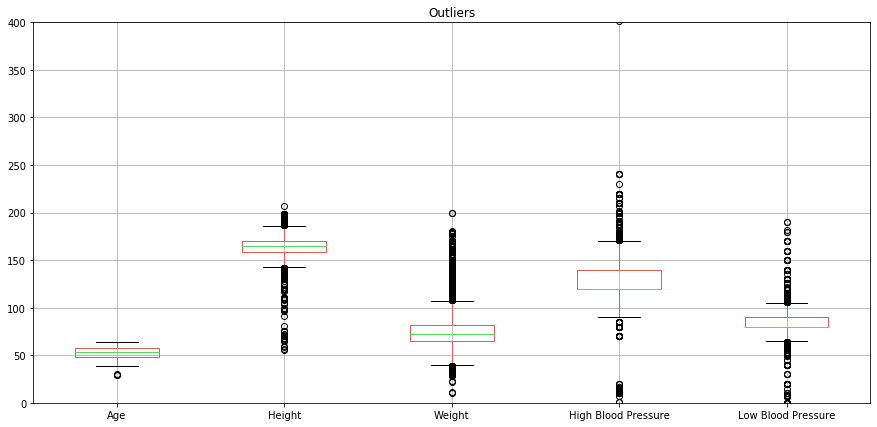

In [116]:
outlier_test = test[['Age','Height','Weight','High Blood Pressure','Low Blood Pressure']]

plt.figure(figsize = (15,7))
a = outlier.boxplot()
a.set_ylim(0,400)
plt.title('Outliers')
plt.show()

**Calculating outlier boundaries**

In [117]:
t_limit = pd.DataFrame(index=['t_Lower','t_Upper'])

for i in ['High Blood Pressure','Low Blood Pressure','Height','Weight']:
    IQR = test[i].quantile(0.75) - test[i].quantile(0.25)
    t_Lower = test[i].quantile(0.25) - (IQR * 3)
    t_Upper = test[i].quantile(0.75) + (IQR * 3)
    t_limit[i]= [t_Lower,t_Upper]
    print('{} outliers are values < {} or > {}'.format(i,t_Lower,t_Upper))
t_limit

High Blood Pressure outliers are values < 60.0 or > 200.0
Low Blood Pressure outliers are values < 50.0 or > 120.0
Height outliers are values < 126.0 or > 203.0
Weight outliers are values < 14.0 or > 133.0


,High Blood Pressure,Low Blood Pressure,Height,Weight
t_Lower,60.0,50.0,126.0,14.0
t_Upper,200.0,120.0,203.0,133.0


**Winsorizing outliers**

In [118]:
test['High Blood Pressure'] = max_(test,'High Blood Pressure',200)
test['Low Blood Pressure'] = max_(test,'Low Blood Pressure',120)
test['Height'] = max_(test,'Height',203)
test['Weight'] = max_(test,'Weight',133)
test['High Blood Pressure'] = min_(test,'High Blood Pressure',60)
test['Low Blood Pressure'] = min_(test,'Low Blood Pressure',50)
test['Height'] = min_(test,'Height',126)
test['Weight'] = min_(test,'Weight',14)

**Label encoding categorical variables**

In [119]:
test.replace({'Gender':{'female':0,'male':1}},inplace=True)
test.replace({'Cholesterol':{'normal':0,'high':1,'too high':2}},inplace=True)
test.replace({'Glucose':{'normal':0,'high':1,'too high':2}},inplace=True) 

**Adding a new feature BMI**

In [120]:
test.insert(4,'BMI', round(test['Weight']/((test['Height']/100)**2),1))

**Looking at descriptive statistics of final test data**

In [121]:
test.describe()

,Age,Gender,Height,Weight,BMI,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise
count,20434.000000,20434.000000,20434.000000,20434.000000,20434.000000,20434.000000,20434.000000,20434.000000,20434.000000,20434.000000,20434.000000,20434.000000
mean,52.808652,0.352892,164.351179,74.375230,27.577797,127.003670,81.888128,0.377802,0.233190,0.090144,0.054077,0.801948
std,6.809867,0.477881,8.059699,14.437527,5.349776,17.635009,10.571675,0.688268,0.579248,0.286395,0.226174,0.398542
min,29.000000,0.000000,126.000000,21.000000,8.000000,60.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,159.000000,65.000000,23.900000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,53.000000,0.000000,165.000000,72.000000,26.500000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,58.000000,1.000000,170.000000,82.000000,30.400000,140.000000,90.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,64.000000,1.000000,203.000000,133.000000,83.800000,200.000000,120.000000,2.000000,2.000000,1.000000,1.000000,1.000000


**head of final test data**

In [122]:
test.head()

,Age,Gender,Height,Weight,BMI,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise
0,44,0,160,59.0,23.0,100,80,1,0,0,0,1
1,41,0,169,74.0,25.9,120,70,0,0,0,0,1
2,63,1,168,84.0,29.8,120,80,0,1,0,0,1
3,55,0,158,108.0,43.3,160,100,0,0,0,0,0
4,55,0,167,67.0,24.0,120,80,0,0,0,0,1


## Prediction on test data

**Scaling test data for distance based algorithms**

In [123]:
scaled_test = StandardScaler().fit_transform(test)

**Naive Bayes classifier**

In [124]:
test_nbc = nbc.predict(test)

In [125]:
test_nbc

array([0, 0, 0, ..., 1, 1, 0])

**K-Nearest Neighbors**

In [126]:
test_knn = knn_tuned.predict(scaled_test)

In [127]:
test_knn

array([0, 0, 0, ..., 0, 1, 0])

**Linear Support Vector machine**

In [128]:
test_lsvm = lsvm.predict(scaled_test)

In [129]:
test_lsvm

array([0, 0, 1, ..., 1, 1, 1])

**Non-Linear Support Vector machine**

In [130]:
test_rbf = rbf_tuned.predict(scaled_test)

In [131]:
test_rbf

array([0, 0, 0, ..., 0, 1, 0])

**Random Forest**

In [132]:
test_rf = rf_tuned.predict(test)

In [133]:
test_rf

array([0, 0, 1, ..., 0, 1, 0])

**Gradient Boosting Machine**

In [134]:
test_gbm = gbm_tuned.predict(test)

In [135]:
test_gbm

array([0, 0, 1, ..., 0, 1, 0])

**Making a final csv file**

In [136]:
final = pd.DataFrame(list(zip(main['ID'],test_nbc,test_knn,test_lsvm,test_rbf,test_rf,test_gbm)),columns=['ID','NBC','KNN','SVM-Linear','SVM-RBF','RF','GBM'])


In [137]:
final.head()

,ID,NBC,KNN,SVM-Linear,SVM-RBF,RF,GBM
0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,2,0,0,1,0,1,1
3,3,1,1,1,1,1,1
4,4,0,0,0,0,0,0


In [138]:
final.to_csv('final.csv',index=False)

### CONCLUSION

*From all the models that we have built and tuned, we learnt the importance of tuning the model parameters and the way it affects the performance of the model. Hyperparameter is an important part of building a machine learning model. Random Forest, Gradient Boosting Machine models and LinearSupport Vector Machine,in order,produced best results and performed better than rest of the models.*